In [2]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

## SGD on weather radar image

In [7]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from regression import OLS

In Project 1 we used matrix inversion to solve the equations for OLS and Ridge. In this exercise I will solve the same equations using stocastic gradient descent. I have choosen to continue with the same weather radar image as I used in the first project:

## Visualize error in OLS and Ridge

In [8]:
import seaborn as sns
from regression import OLS
from regression_analytic import Ridge as Ridge_analytic
import tqdm
from franke_function import FrankeFunction as Fr
    
#sk-learn linear regression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

learning_rate = np.logspace(-5, 0, 6)
regularization = np.linspace(0, 1, len(learning_rate))
alpha = 0.9
poly_deg = 7 
k_folds = 5
batch_size = 256
n_epochs = 200

train_accuracy = np.zeros((len(learning_rate), len(regularization)))
test_accuracy = np.zeros((len(learning_rate), len(regularization)))


#Use radar data:
#z = radar_rescaled
#x = np.arange(z.shape[1])
#y = np.arange(z.shape[0])
#x, y = np.meshgrid(x, y)

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)
noise = np.random.randn(x.shape[0], y.shape[1])
z = Fr(x, y) + noise*0.05

xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

# my own SGD implementation for OLS and Ridge
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
    
            #Scale groups using train mean and std
            xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
            xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
            z_test[:] =  z_test[:] - np.mean(z_train[:]) 
            xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
            xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
            z_train[:] =  z_train[:] - np.mean(z_train[:])
        
            model = OLS(poly_deg, 
                        regularization[j], 
                        learning_rate[i], 
                        alpha, 
                        batch_size =batch_size, 
                        n_epochs = n_epochs)
            model.fit(xy_train, z_train) 
            R2_test.append(model.R2(xy_test, z_test)) 
            R2_train.append(model.R2(xy_train, z_train))

        train_accuracy[i][j] = np.mean(R2_train)
        test_accuracy[i][j] = np.mean(R2_test)

 83%|███▎| 5/6 [02:46<00:32, 32.24s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in add
  return f_raw(*args, **kwargs)
/home/erlend/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
/home/erlend/Documents/GitHub/FYS-STK4155/Project_2/regression.py:132: RuntimeWarning: overflow encountered in square
  return 1 - np.sum(( z.reshape(-1, 1) - z_pred.reshape(-1, 1) )**2)/np.sum(
100%|████| 6/6 [03:16<00:00, 32.76s/it]


In [10]:
# ScikitLearn for comparison
poly_deg = 7
train_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))
test_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test_skl = []
        R2_train_skl = []
        for k in range(k_folds):     
            # extract folds
    
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
    
            #Scale groups using train mean and std
            xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
            xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
            z_test[:] =  z_test[:] - np.mean(z_train[:]) 
            xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
            xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
            z_train[:] =  z_train[:] - np.mean(z_train[:])
            
            
            model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg),
                                      SGDRegressor(learning_rate='constant',
                                                   eta0=learning_rate[i],
                                                   max_iter=2000,
                                                   alpha = regularization[j]))
            model_skl.fit(xy_train, z_train.ravel()) 
            skl_predict_test = model_skl.predict(xy_test)
            skl_predict_train = model_skl.predict(xy_train)
            R2_test_skl.append( r2_score(z_test.ravel(), skl_predict_test ) )
            R2_train_skl.append( r2_score(z_train.ravel(), skl_predict_train ) )
            
        train_accuracy_skl[i][j] = np.mean(R2_train_skl)
        test_accuracy_skl[i][j] = np.mean(R2_test_skl)

100%|████| 6/6 [00:00<00:00,  6.35it/s]


In [14]:
# analytical for comparison
poly_deg = 22
train_accuracy_a = np.zeros((len(learning_rate), len(regularization)))
test_accuracy_a = np.zeros((len(learning_rate), len(regularization)))
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test_a = []
        R2_train_a = []
        for k in range(k_folds):     
            # extract folds
    
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
    
            #Scale groups using train mean and std
            xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
            xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
            z_test[:] =  z_test[:] - np.mean(z_train[:]) 
            xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
            xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
            z_train[:] =  z_train[:] - np.mean(z_train[:])
            
            model_a = Ridge_analytic(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(),
                                     poly_deg, regularization[j])
            a_predict_test = model_a.predict(xy_test[:, 0], xy_test[:, 1]) 
            a_predict_train = model_a.predict(xy_train[:, 0], xy_train[:, 1]) 
            R2_test_a.append( r2_score(z_test.ravel(), a_predict_test) ) 
            R2_train_a.append( r2_score(z_train.ravel(), a_predict_train) )
                              
        train_accuracy_a[i][j] = np.mean(R2_train_a)
        test_accuracy_a[i][j] = np.mean(R2_test_a)


100%|████| 6/6 [00:19<00:00,  3.18s/it]


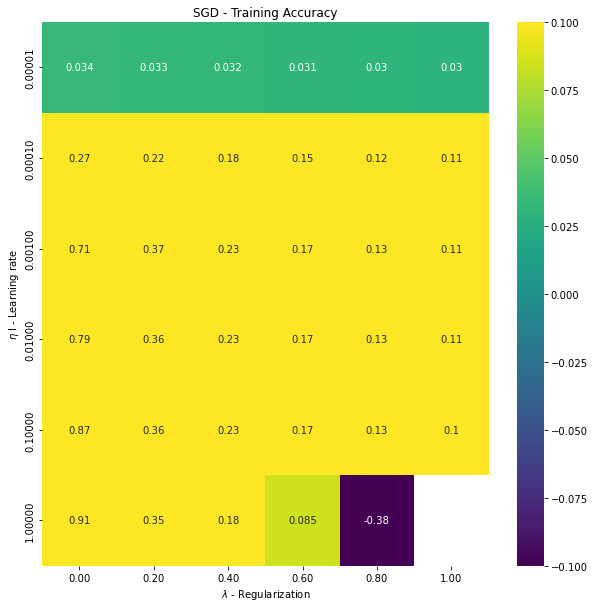

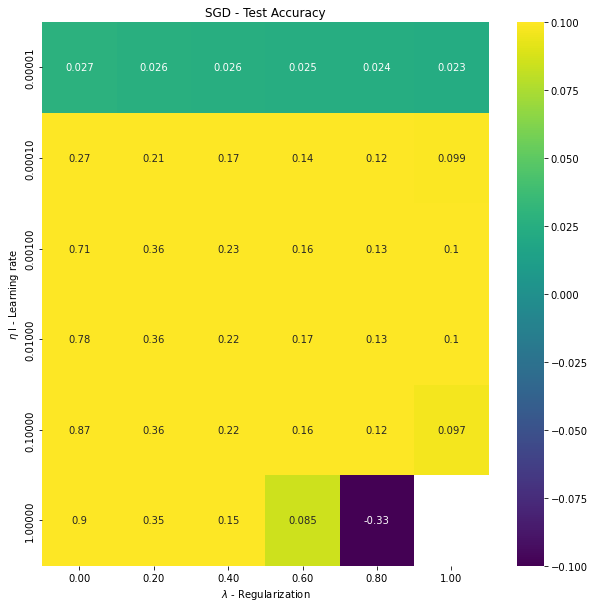

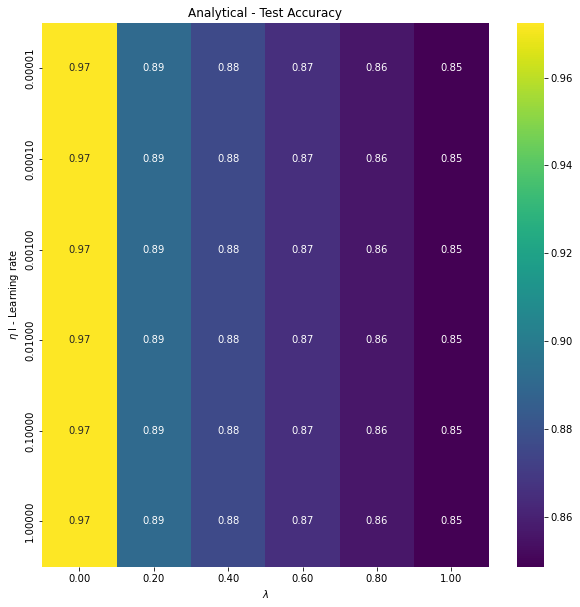

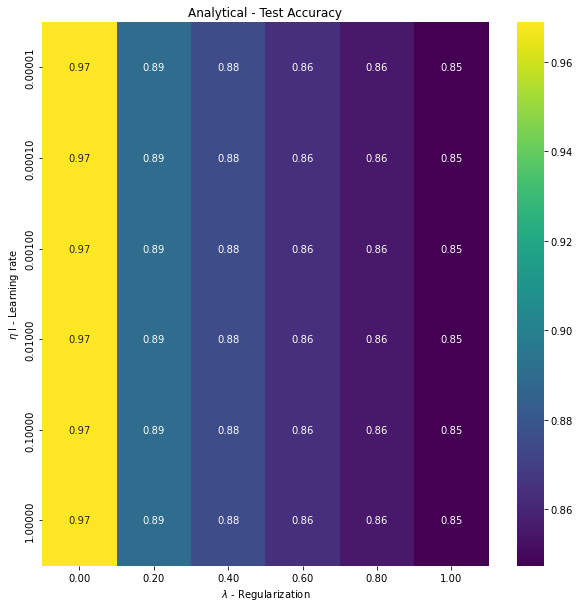

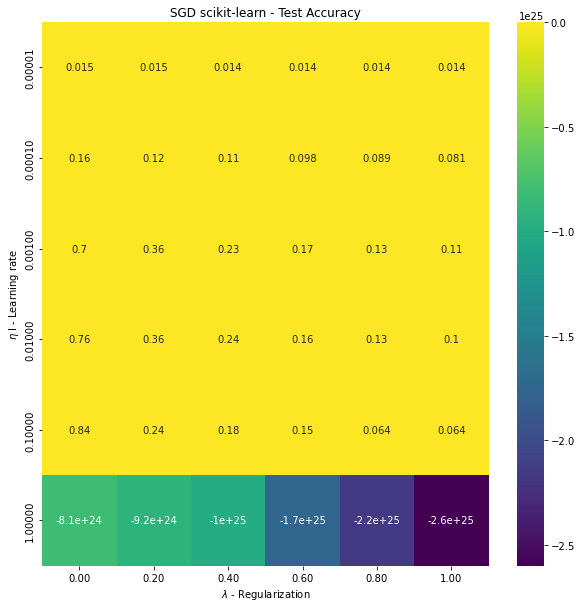

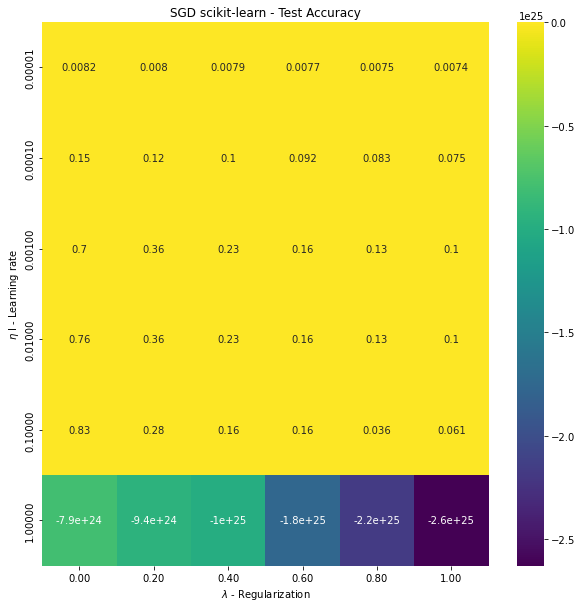

In [16]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("SGD - Training Accuracy")
ax.set_ylabel("$\eta$ l - Learning rate")
ax.set_xlabel("$\lambda$ - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("SGD - Test Accuracy")
ax.set_ylabel("$\eta$ l - Learning rate")
ax.set_xlabel("$\lambda$ - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy_a, annot=True, ax=ax, cmap="viridis")
ax.set_title("Analytical - Test Accuracy")
ax.set_ylabel("$\eta$ l - Learning rate")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_a, annot=True, ax=ax, cmap="viridis")
ax.set_title("Analytical - Test Accuracy")
ax.set_ylabel("$\eta$ l - Learning rate")
ax.set_xlabel("$\lambda$ - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("SGD scikit-learn - Test Accuracy")
ax.set_ylabel("$\eta$ l - Learning rate")
ax.set_xlabel("$\lambda$ - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("SGD scikit-learn - Test Accuracy")
ax.set_ylabel("$\eta$ l - Learning rate")
ax.set_xlabel("$\lambda$ - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()